# Plot light curves

**Abstract:** Here we check the performance of models by investigating their behaviour on generating a LC from the grid.

In [1]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from nmma.em.training import SVDTrainingModel
import nmma as nmma
import time
import arviz

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans

import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}

model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Install wrapt_timeout_decorator if you want timeout simulations.


## Preprocessing data

In [7]:
# Choose model and set location of the kilonova lightcurves
bulla_2022_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/bulla_2022"
bulla_2019_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/bulla_2019"
bulla_2023_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/bulla_2023"

# Choose the model here
# model_name = "Bu2022Ye"
model_name = "Bu2023Ye"
model_function = MODEL_FUNCTIONS[model_name]

# Set the location of the lightcurves and outdir based on chosen model
if model_name == "Bu2022Ye":
    lcs_dir = bulla_2022_dir
    
elif model_name == "Bu2019lm":
    lcs_dir = bulla_2019_dir

elif model_name == "Bu2023Ye":
    lcs_dir = bulla_2023_dir

svd_path = f"/home/urash/twouters/new_nmma_models/"
old_svd_path = f"/home/urash/twouters/nmma_models/"

# Process the KN lightcurves
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

print("Reading lightcurves and interpolating NaNs...")
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))

print("Reading lightcurves and interpolating NaNs... DONE")

# Get the time array
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
t = dat["t"].values

print("Genrating training data...")
training_data, parameters = model_function(data)
print("Genrating training data... DONE")

There are 33792 lightcurves for this model.
Reading lightcurves and interpolating NaNs...
Reading lightcurves and interpolating NaNs... DONE
Filters:
['2massh', '2massj', '2massks', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu']
Genrating training data...
Genrating training data... DONE


## Get the models

In [8]:
from nmma.em.model import SVDLightCurveModel

print("Loading new LC model...")
new_lc_model = SVDLightCurveModel(
        model_name,
        t,
        svd_path=svd_path,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="tensorflow",
        model_parameters=None,
        local_only=True
)
print("Loading new LC model... DONE")

Loading new LC model...
Loaded filter 2massh


2024-01-08 13:19:53.721128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 13:19:54.294507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22776 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5


Loaded filter 2massj
Loaded filter 2massks
Loaded filter ps1__g
Loaded filter ps1__i
Loaded filter ps1__r
Loaded filter ps1__y
Loaded filter ps1__z
Loaded filter sdssu
Loading new LC model... DONE


## Get the input and output pairs of lightcurve grid

In [9]:
def get_input_values(training_data: dict, parameters: list) -> np.ndarray:
    """
    From a dictionary of training data, extract the input values for the model.
    """
    
    input_values = []
    
    for key in training_data.keys():
        data = training_data[key]
        input_values.append([data[param] for param in parameters])
    
    return np.array(input_values)

In [10]:
def get_output_values(training_data: dict) -> np.ndarray:
    """
    From a dictionary of training data, extract the output values for the model.
    """
    keys = list(training_data.keys())
    if "data" in training_data[keys[0]].keys():
        # This is the version that was in use for NMMA-GPU
        output_values = [training_data[key]["data"] for key in training_data.keys()]
    else:
        # This is the version for NMMA CPU, 12/12/2023
        output_values = []
        for key in training_data.keys():
            data = training_data[key]
            new_list = [data[f] for f in filts]
            output_values.append(new_list)
    
    return np.array(output_values)

In [11]:
# Sanity check:
keys = list(training_data.keys())
example = training_data[keys[0]]
print(example.keys())

dict_keys(['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'Yewind', 'KNtheta', 't', 'sdssu', 'ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', '2massj', '2massh', '2massks'])


In [12]:
input_values = get_input_values(training_data, parameters)
output_values = get_output_values(training_data)

In [13]:
print(np.shape(input_values))
print(np.shape(output_values))

(33792, 7)
(33792, 9, 100)


In [16]:
N = 200
# Select a random subset of indices for the input values
idx_list = np.random.choice(len(input_values), N, replace=False)
sampled_input_values = input_values[idx_list]
sampled_output_values = output_values[idx_list]

Get both outputs flax output

In [17]:
# For this list, we compute the LCs using the flax model
start = time.time()

new_lc_model_output = []

for i in range(len(sampled_input_values)):
    # Compute the lightcurve
    _, _, mag = nmma.em.utils.calc_lc(t,
                                sampled_input_values[i], 
                                svd_mag_model = new_lc_model.svd_mag_model, 
                                interpolation_type="tensorflow", 
                                filters = filts, 
                                mag_ncoeff = 10
                                )
    # Convert this dictionary to values of the LCs
    mag = mag.values()
    mag = np.array(list(mag))
    new_lc_model_output.append(mag)
end = time.time()
print(f"Computing all the lightcurves for a subset of {N} lightcurves took {end-start} seconds for both new and old model.")

# Convert to np arrays
new_lc_model_output = np.array(new_lc_model_output)

Computing all the lightcurves for a subset of 200 lightcurves took 3.7649731636047363 seconds for both new and old model.


## Compare MSE or MAE values

TODO: Best to compare this as a distribution, and perhaps best to consider MAE, or some self-defined loss function or error function?

In [18]:
def mse(y_true, y_pred, axis=None):
    return np.mean((y_true - y_pred)**2, axis=axis)

def se(y_true, y_pred):
    return (y_true - y_pred)**2

def mae(y_true, y_pred, axis=None):
    return np.mean(np.abs(y_true - y_pred), axis=axis)

def ae(y_true, y_pred):
    return np.abs(y_true - y_pred)

def my_format(low: float, med: float, high: float, nb: int = 3) -> str:
    med = np.round(med, nb)
    low = med - low
    low = np.round(low, nb)
    high = high - med
    high = np.round(high, nb)
    
    return f"{med} - {low} + {high}"

# # TODO with arviz summarize the errors
# def summarize_data(values: np.array, percentile: float = 0.95) -> None:
    
#     med = np.median(values)
#     result = arviz.hdi(values, hdi_prob = percentile)
    
#     print(my_format(low, med, high))
    
#     return

In [19]:
# which_dataset = flax_output
# which_error = mae
nb_round = 5
for error_fn, name in zip([mse, mae], ["MSE", "MAE"]):
    for dataset, dataset_name in zip([new_lc_model_output], ["new"]):
        # diffs = se(dataset, sampled_output_values)
        print(f"Computing {name} for {dataset_name} model...")
        axis = 0
        mse_values = error_fn(dataset, sampled_output_values, axis=axis)
        mse_values = np.mean(mse_values, axis=0)
        for f, val in zip(filts, mse_values):
            print(f"{f}: {np.round(val, nb_round)}")

Computing MSE for new model...
2massh: 12.44931
2massj: 7.54048
2massks: 5.18366
ps1__g: 3.75592
ps1__i: 3.17308
ps1__r: 2.02723
ps1__y: 1.46506
ps1__z: 1.28498
sdssu: 1.0849
Computing MAE for new model...
2massh: 2.00216
2massj: 1.74552
2massks: 1.45282
ps1__g: 1.26377
ps1__i: 1.14937
ps1__r: 1.00259
ps1__y: 0.87644
ps1__z: 0.81643
sdssu: 0.7686


## Plot lightcurves

(33792, 9, 100)


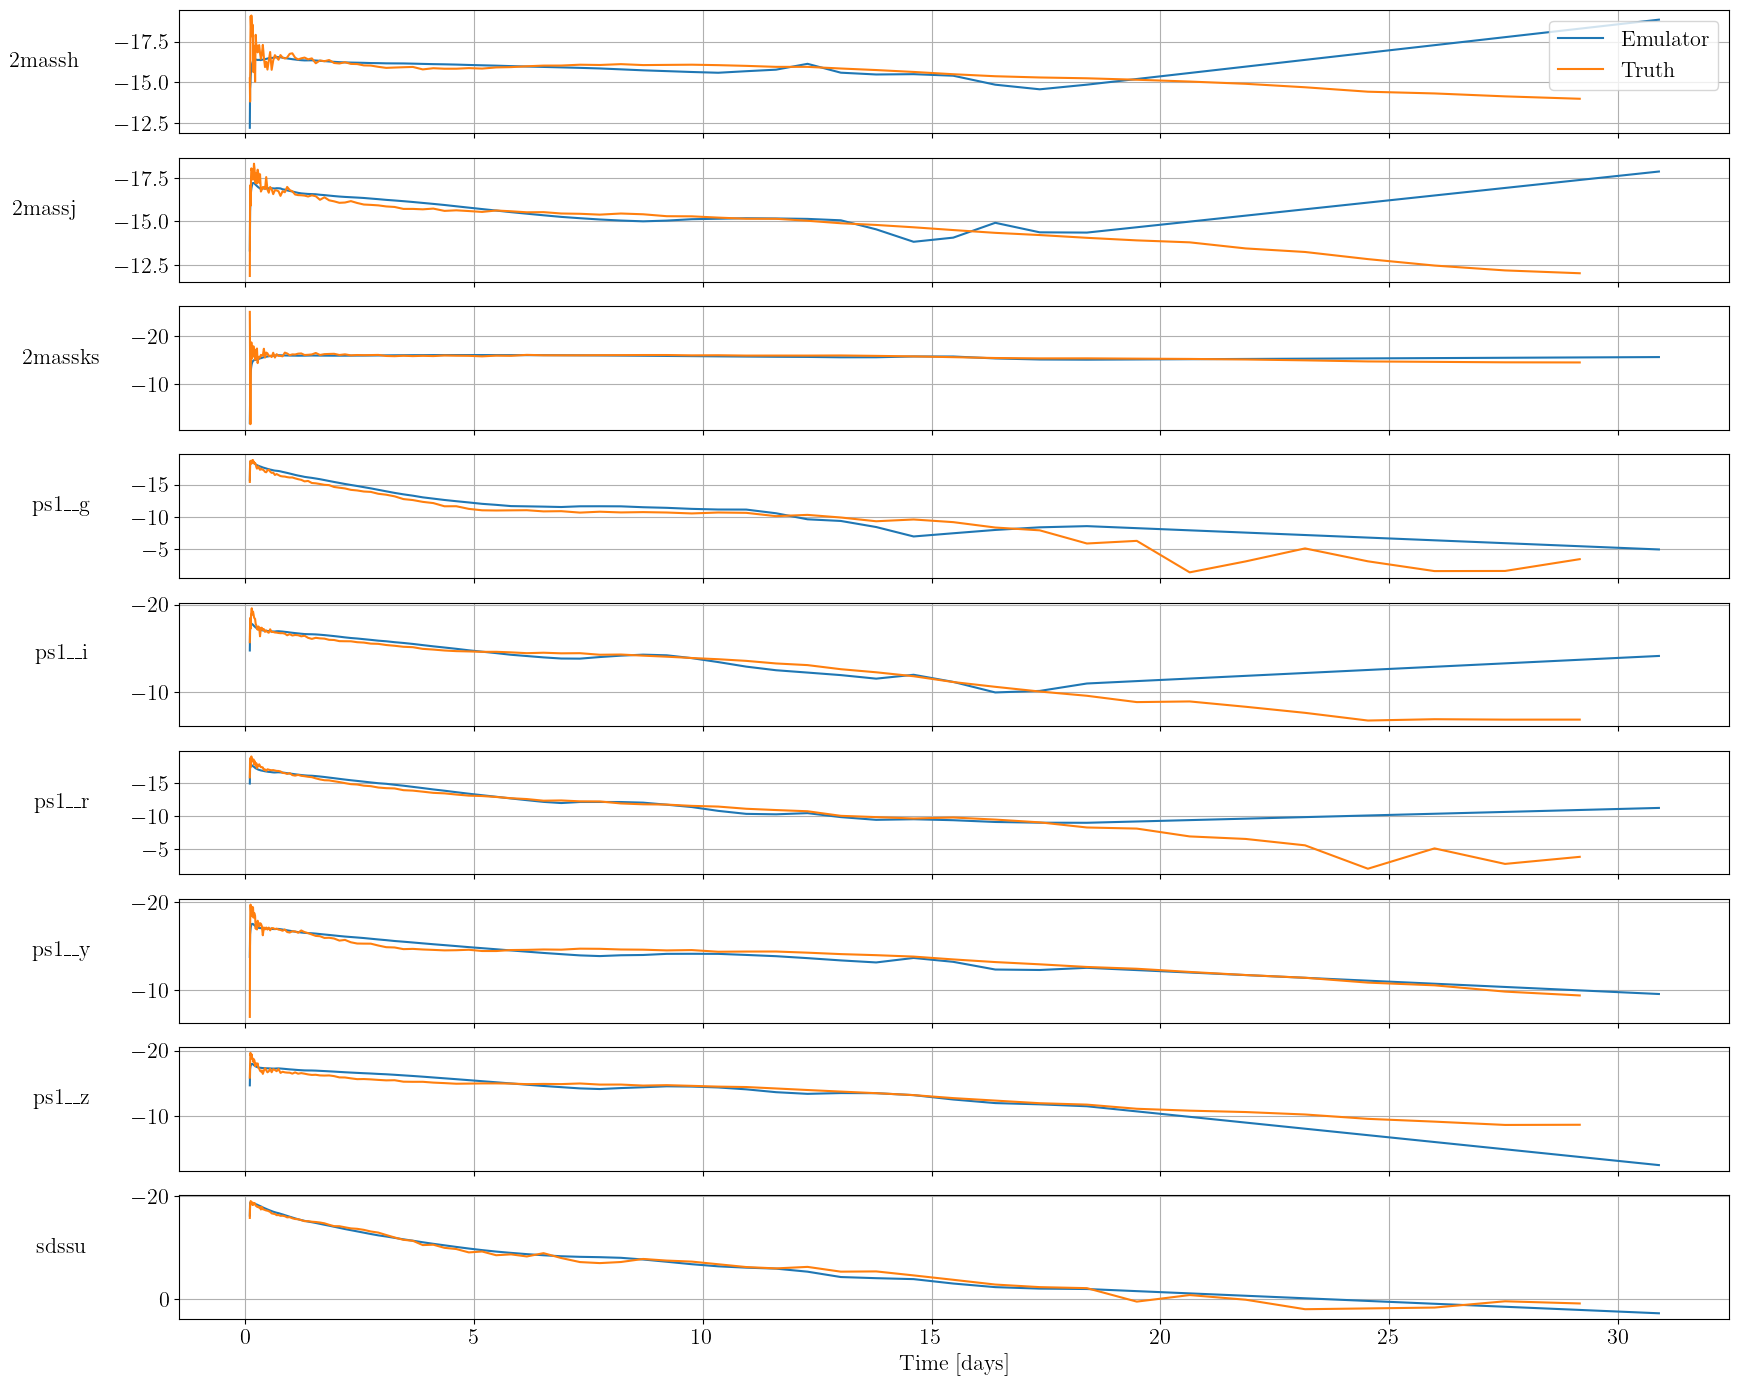

In [47]:
index = 16

example_key = list(training_data.keys())[index]
example = training_data[example_key]
parameter_values = [example[p] for p in parameters]
output = get_output_values(training_data)
print(np.shape(output))
truth = output[index]

_, _, mag = nmma.em.utils.calc_lc(t,
                            parameter_values, 
                            svd_mag_model = new_lc_model.svd_mag_model, 
                            interpolation_type="tensorflow", 
                            filters = filts, 
                            mag_ncoeff = 10
                            )

# Compute the lightcurve
nrow = len(filts)
fig, axs = plt.subplots(nrow, 1, figsize=(20, 17), sharex = True)
t = dat["t"].values

for i, key in enumerate(filts):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, mag[key], label="Emulator")
    plt.plot(t, truth[i], label="Truth")
    plt.ylabel(key, rotation=0, labelpad=50)
    axs[i].invert_yaxis()
    # plt.grid()
    if i == 0:
        plt.legend()
plt.xlabel("Time [days]")
plt.show()